In [ ]:
import gdown

file_id = '1_5bOckQPXI_pAkboJ8kS43ebHe65VeXo'
output = 'dataset-sampah.zip'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1_5bOckQPXI_pAkboJ8kS43ebHe65VeXo
From (redirected): https://drive.google.com/uc?id=1_5bOckQPXI_pAkboJ8kS43ebHe65VeXo&confirm=t&uuid=bfe3af43-1cd0-4d21-9f79-aa729ef3c0f2
To: c:\Users\Administrator\Documents\Codding\DSA_tugas_akhir-master\Deteksi Sampah CNN\dataset-sampah.zip
100%|██████████| 42.8M/42.8M [00:19<00:00, 2.24MB/s]


'dataset-sampah.zip'

In [2]:
# 1. Environment setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# 2. Import libraries
from pathlib import Path
from sklearn.metrics import confusion_matrix
from fastai.vision.all import *
import random, pandas as pd, numpy as np
import os, zipfile, shutil, re, seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# 3. Unzip dataset
with zipfile.ZipFile("dataset-sampah.zip", 'r') as zip_ref:
    zip_ref.extractall()


In [5]:
# 4. Cek isi folder
base_dir = Path("dataset-sampah")
print(os.listdir(base_dir))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [ ]:
# 5. Fungsi pembagi dataset
def split_indices(folder, seed1=42, seed2=99):
    n = len(os.listdir(folder))
    full_set = list(range(1, n+1))
    random.seed(seed1)
    train = random.sample(full_set, int(0.5 * n))
    remain = list(set(full_set) - set(train))
    random.seed(seed2)
    valid = random.sample(remain, int(0.5 * len(remain)))
    test = list(set(remain) - set(valid))
    return train, valid, test

In [7]:
# 6. Get filename
def get_names(waste_type, indices):
    return [f"{waste_type}{i}.jpg" for i in indices]

In [8]:
# 7. Pindahkan file
def move_files(source_files, destination_folder):
    for file in source_files:
        shutil.move(str(file), str(destination_folder))

In [9]:
# 8. Buat struktur folder dan pindahkan data
subsets = ['train', 'valid']
waste_types = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

for subset in subsets:
    for wt in waste_types:
        Path(f"data/{subset}/{wt}").mkdir(parents=True, exist_ok=True)

Path("data/test").mkdir(parents=True, exist_ok=True)

for wt in waste_types:
    source_folder = base_dir/wt
    train_idx, valid_idx, test_idx = split_indices(source_folder)
    
    for name_list, subset_folder in zip(
        [train_idx, valid_idx, test_idx],
        [f"data/train/{wt}", f"data/valid/{wt}", "data/test"]
    ):
        fnames = get_names(wt, name_list)
        move_files([source_folder/f for f in fnames], Path(subset_folder))

In [10]:
# 9. Path ke data
path = Path("data")

In [11]:
# 10. Load data menggunakan FastAI v2
dls = ImageDataLoaders.from_folder(
    path, 
    train='train', 
    valid='valid',
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(flip_vert=True),
    bs=10
)


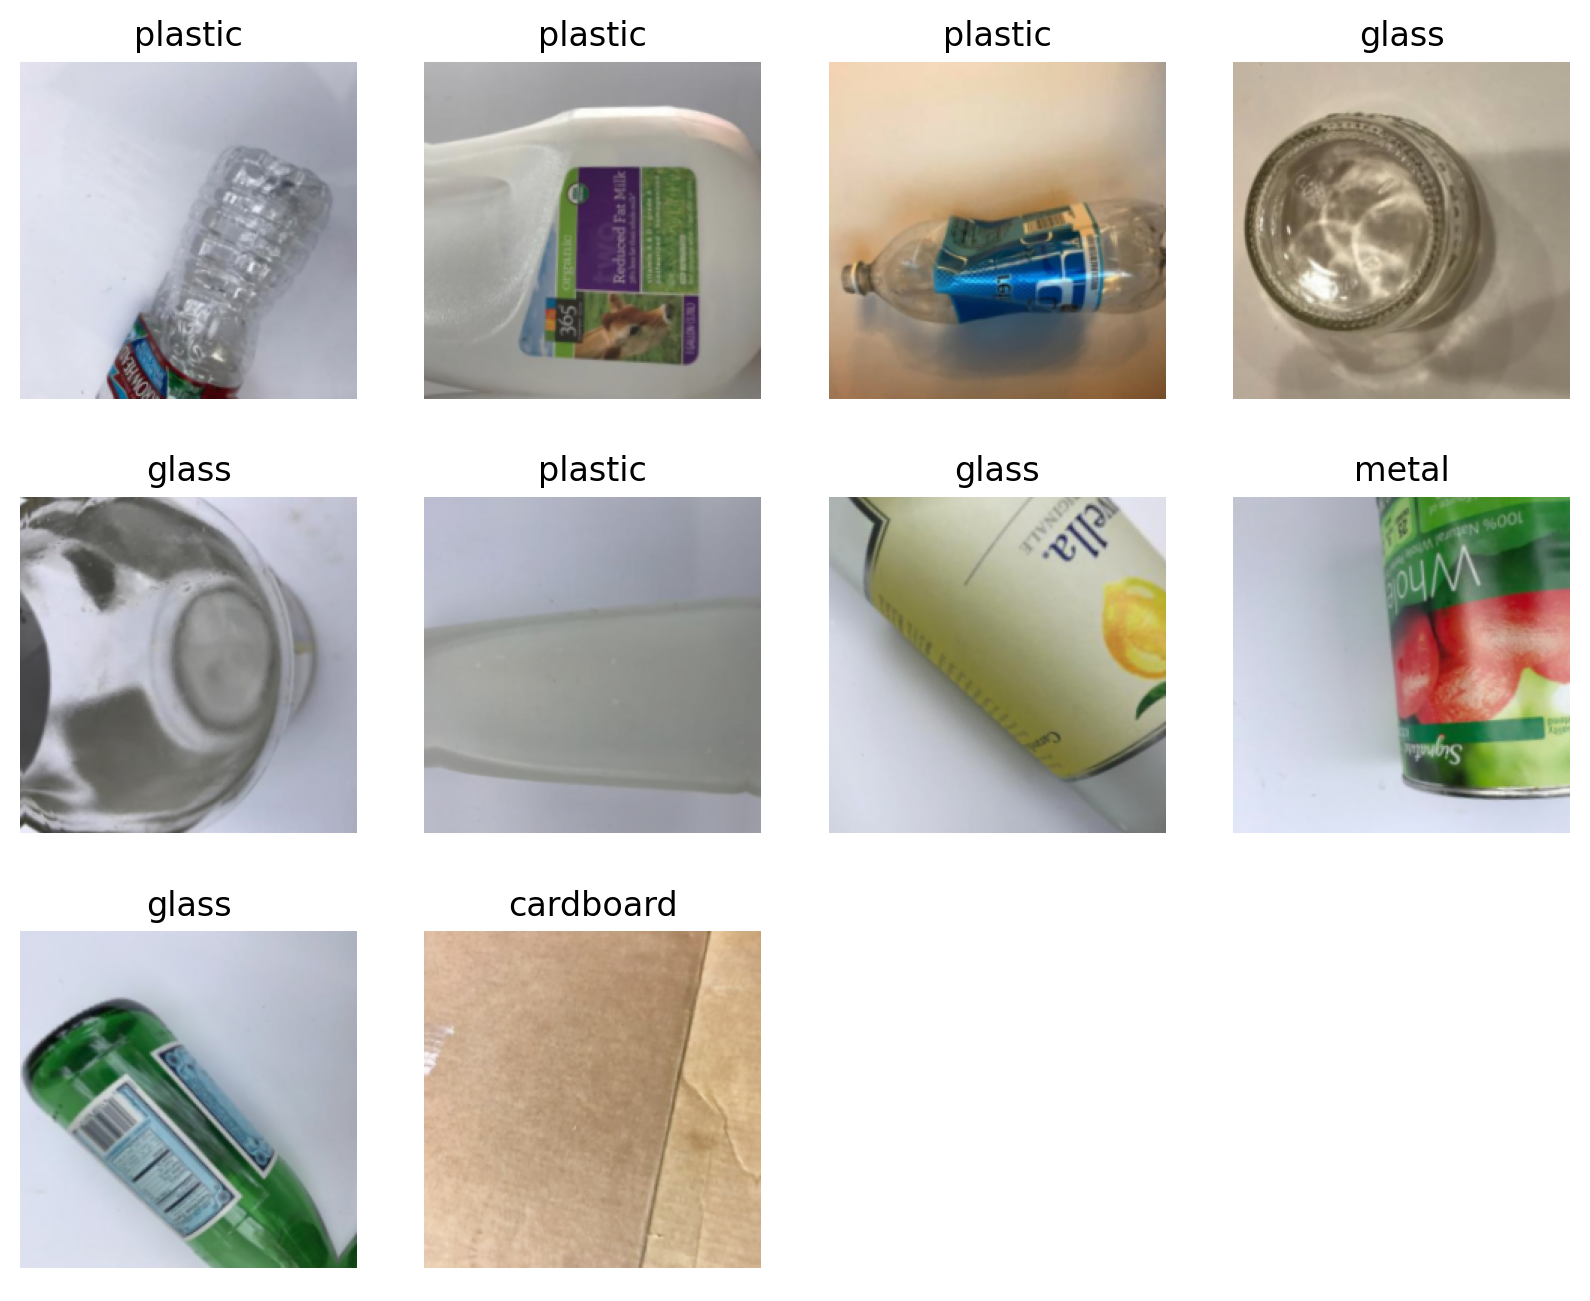

In [12]:
# 11. Cek batch
dls.show_batch(max_n=12, figsize=(10, 8))


In [13]:
# 12. Model dan training
learn = cnn_learner(dls, resnet34, metrics=error_rate)

c:\Python313\Lib\site-packages\fastai\vision\learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\Administrator/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:38<00:00, 2.25MB/s]


SuggestedLRs(valley=0.0010000000474974513)

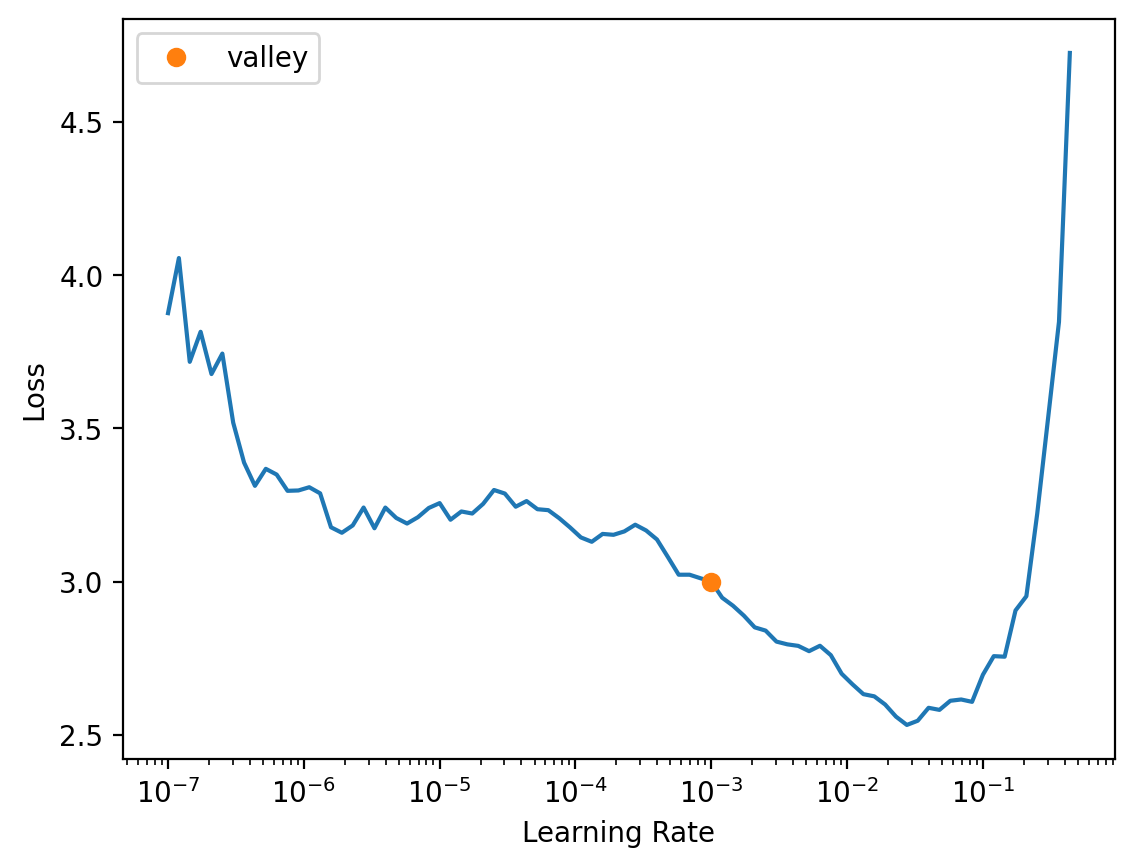

In [14]:
# 13. Learning rate finder
learn.lr_find()

In [15]:
# 14. Training
learn.fine_tune(3, base_lr=1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,1.754479,1.614465,0.339683,04:40


epoch,train_loss,valid_loss,error_rate,time
0,1.486429,1.324627,0.334921,05:57
1,1.169950,0.561020,0.188889,05:58
2,0.750966,0.470611,0.158730,06:24


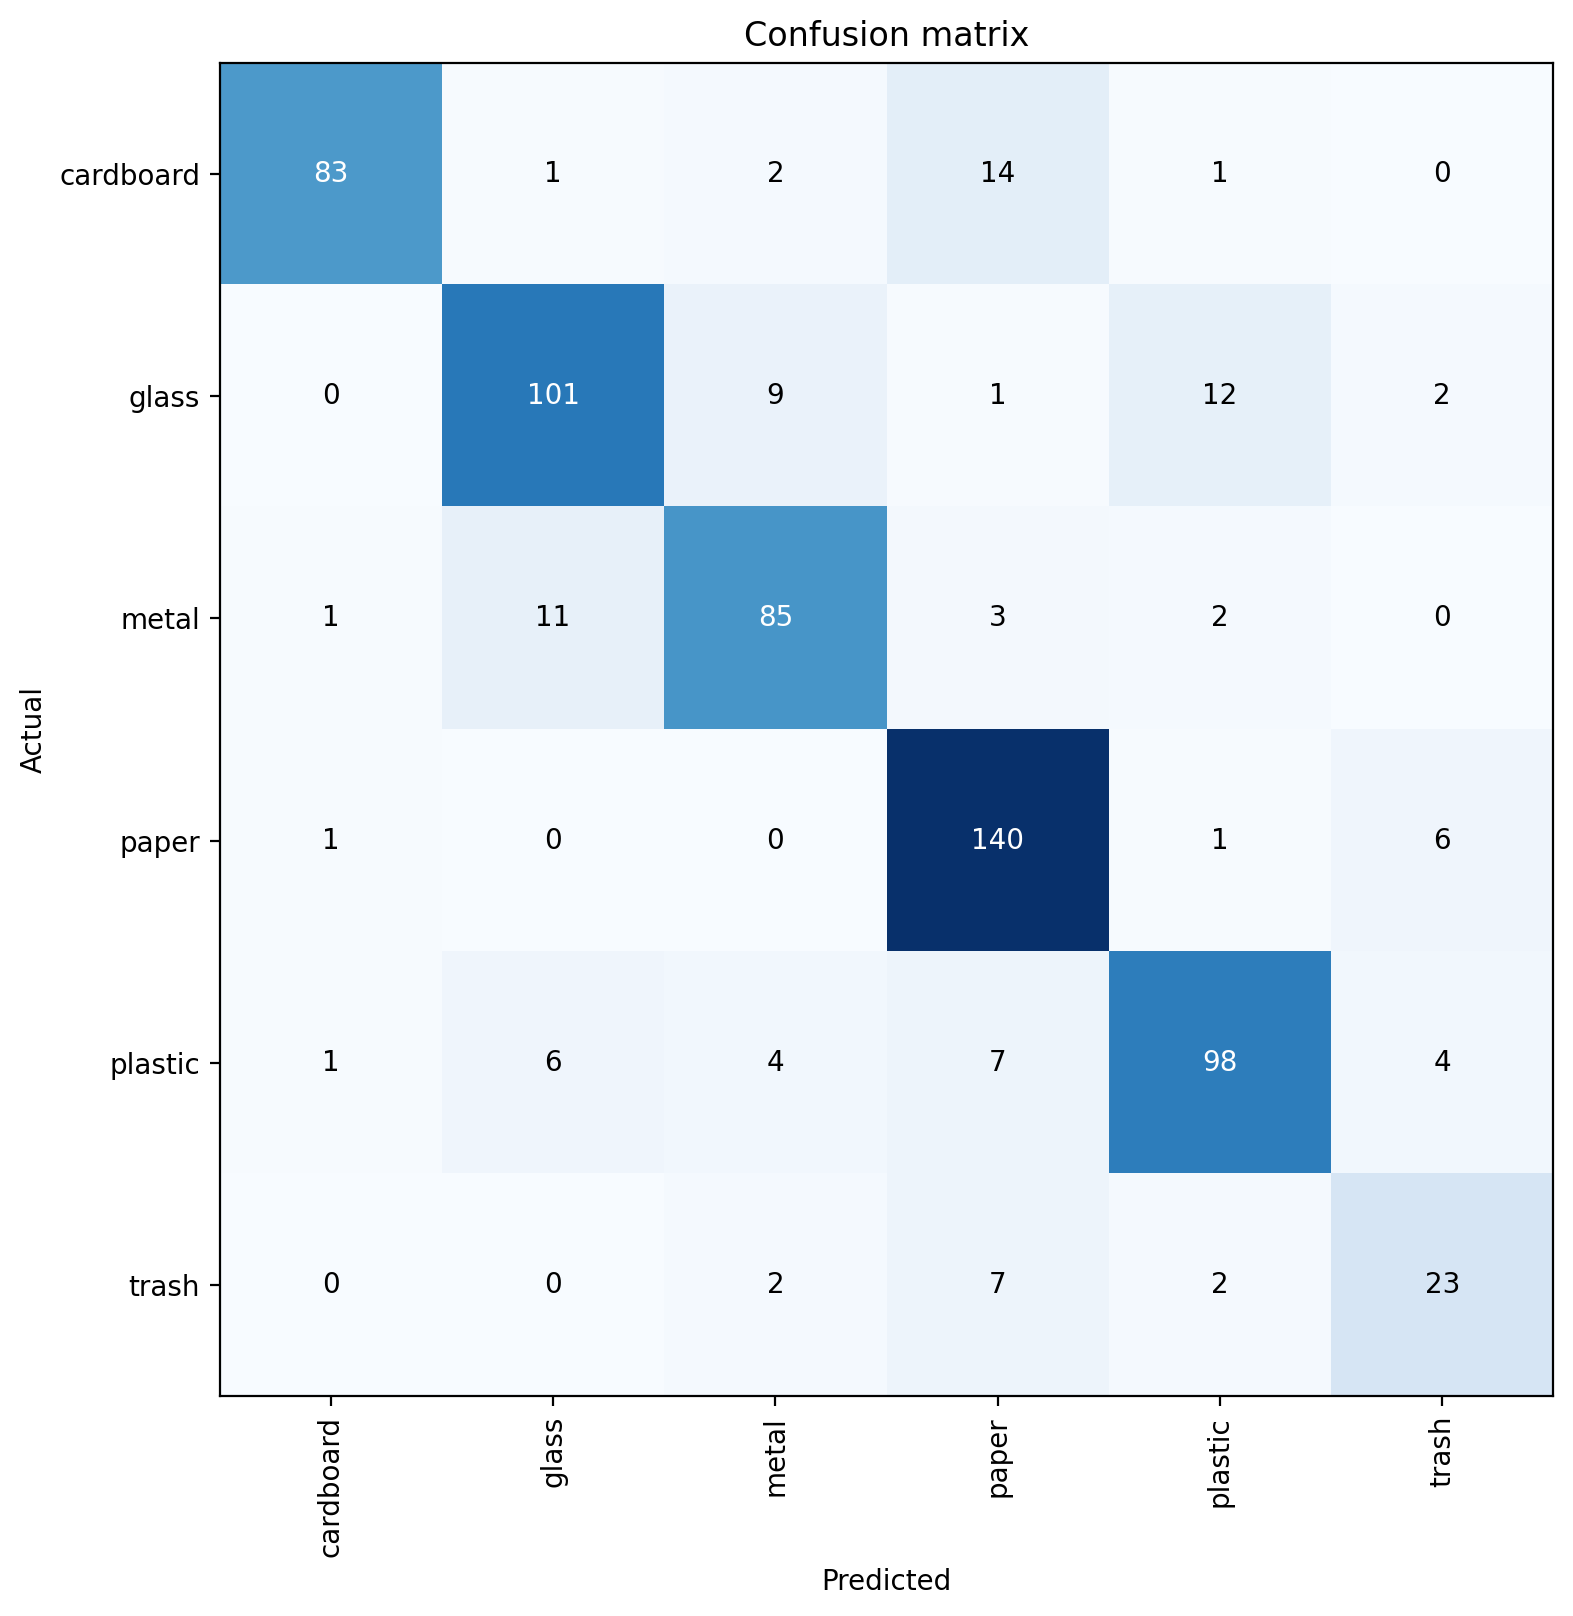

In [16]:
# 15. Evaluasi
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8, 8))

In [17]:
# 16. Prediksi di test set
test_path = path/'test'
test_files = get_image_files(test_path)
test_dl = learn.dls.test_dl(test_files)
preds, _ = learn.get_preds(dl=test_dl)

In [18]:
# 17. Konversi prediksi ke label
labels = learn.dls.vocab
max_idxs = preds.argmax(dim=1)
yhat = [labels[i] for i in max_idxs]


In [19]:
# 18. Ekstraksi label ground truth dari nama file
y = [re.search(r'([a-z]+)[0-9]+', f.name).group(1) for f in test_files]


<Axes: >

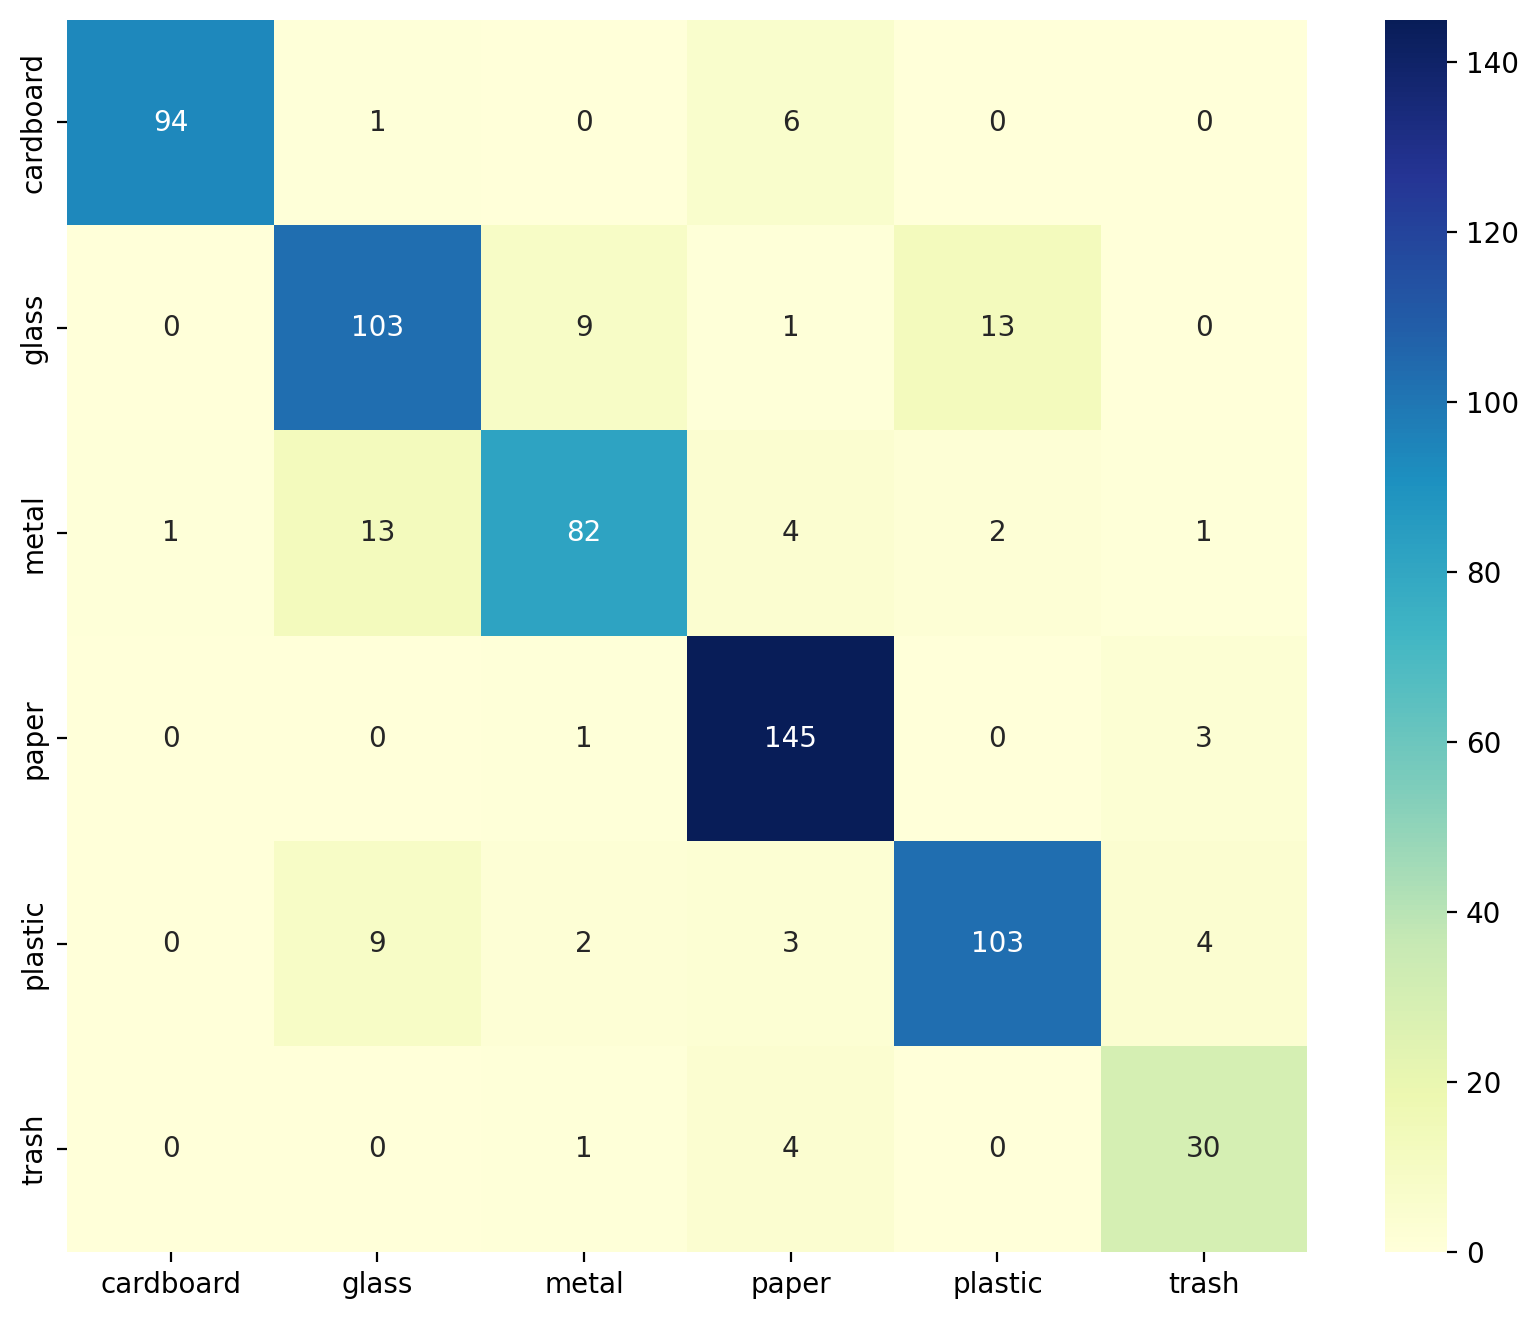

In [20]:
# 19. Confusion matrix
cm = confusion_matrix(y, yhat, labels=waste_types)
df_cm = pd.DataFrame(cm, index=waste_types, columns=waste_types)
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='YlGnBu')

In [21]:
# 20. Akurasi manual
accuracy = np.trace(cm) / np.sum(cm)
print(f"Akurasi: {accuracy:.4f}")

Akurasi: 0.8772


In [ ]:
# 21. Error paling sering
print(interp.most_confused(min_val=2))  

[('cardboard', 'paper', np.int64(14)), ('glass', 'plastic', np.int64(12)), ('metal', 'glass', np.int64(11)), ('glass', 'metal', np.int64(9)), ('plastic', 'paper', np.int64(7)), ('trash', 'paper', np.int64(7)), ('paper', 'trash', np.int64(6)), ('plastic', 'glass', np.int64(6)), ('plastic', 'metal', np.int64(4)), ('plastic', 'trash', np.int64(4)), ('metal', 'paper', np.int64(3)), ('cardboard', 'metal', np.int64(2)), ('glass', 'trash', np.int64(2)), ('metal', 'plastic', np.int64(2)), ('trash', 'metal', np.int64(2)), ('trash', 'plastic', np.int64(2))]
